# Clustering Neighborhoods in Toronto

In this assignment, you will be required to explore, segment, and cluster the neighborhoods in the city of Toronto based on the postalcode and borough information.

For the Toronto neighborhood data, a Wikipedia page exists that has all the information we need to explore and cluster the neighborhoods in Toronto. You will be required to scrape the Wikipedia page and wrangle the data, clean it, and then read it into a pandas  dataframe so that it is in a structured format.

Once the data is in a structured format, you can cluster Toronto neighborhoods.

In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup

### Retrieving data

1. Get the html data from the url page using Requests
2. Get postal codes and neighborhood data using BeautifulSoup

In [2]:
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
html_data  = requests.get(url).text

soup = BeautifulSoup(html_data,"html5lib")  # create a soup object using the variable 'data'
table = soup.find('table')
postal_codes = table.find_all('p')

3. Structure data into a pandas data frame

In [3]:
postal_codes_data = []

for i, postal_code in enumerate(postal_codes):

    if postal_code.span.text == 'Not assigned':
        pass
    else:
        dic = {}
        dic['PostalCode'] = postal_code.find('b').text.strip(' ')
        text = postal_code.span.text.split(sep='(')
        dic['Borough'] = text[0].strip(' ')
        dic['Neighboors'] = text[1].split(sep=')')[0].replace(' /',',').strip(' ')
        
        postal_codes_data.append(dic)
        
toronto_neighboors = pd.DataFrame(data=postal_codes_data)
toronto_neighboors['Borough']=toronto_neighboors['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
                                             'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                             'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto',
                                             'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})
toronto_neighboors.head(8)

,PostalCode,Borough,Neighboors
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Queen's Park,Ontario Provincial Government
5,M9A,Etobicoke,Islington Avenue
6,M1B,Scarborough,"Malvern, Rouge"
7,M3B,North York,Don Mills


In [4]:
toronto_neighboors.shape

(103, 3)

### Extract geospatial data from Toronto neighboors using CSV (geocoder does not work)

1. Read CSV file

In [5]:
geo_data = pd.read_csv('Geospatial_coordinates.csv')
geo_data.head(7)

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476
5,M1J,43.744734,-79.239476
6,M1K,43.727929,-79.262029


5. Formating geospatial information into Toronto neighboors table

In [6]:
postal_codes = geo_data['Postal Code']
toronto_geodata = toronto_neighboors

for row in range(0,len(geo_data)):
    
    cp = geo_data.iloc[row,0]
    latitude = geo_data.iloc[row,1]
    longitude = geo_data.iloc[row,2]
    
    toronto_geodata.loc[(toronto_geodata['PostalCode']==cp),'Latitude'] = latitude
    toronto_geodata.loc[(toronto_geodata['PostalCode']==cp),'Longitude'] = longitude

# toronto_geodata.dropna(inplace = True)

In [7]:
toronto_geodata.head(7)

,PostalCode,Borough,Neighboors,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494
5,M9A,Etobicoke,Islington Avenue,43.667856,-79.532242
6,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353


In [8]:
toronto_geodata.iloc[6]

PostalCode               M1B
Borough          Scarborough
Neighboors    Malvern, Rouge
Latitude           43.806686
Longitude         -79.194353
Name: 6, dtype: object

### Create map of Toronto using latitude and longitude values

Put pin points in Toronto map for each neighborhood using Geopy to find Toronto and Folium for maping. 

In [9]:
from geopy.geocoders import Nominatim
import folium

address = 'Toronto, TR'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# toronto_geodata = toronto_geodata[0:50]

# add markers to map
for lat, lng, borough, neighborhood in zip(toronto_geodata['Latitude'], toronto_geodata['Longitude'], 
                                           toronto_geodata['Borough'], toronto_geodata['Neighboors']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

The geograpical coordinate of Toronto are 43.6679901, -79.3692631.


### Retrieve venues near Toronto neighboors using Foresquare

1. Set Foresquare credentials

In [10]:
CLIENT_ID = 'NEVX3TDYCFCQQK1QED2NJUHRQXGMAZIIL3NTLQMZDWSUDD4X' # your Foursquare ID
CLIENT_SECRET = 'GPM2X423F3CQQXOHGOKVVG030ZI4PX4MP4V4E2X1YV0IV5MT' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: NEVX3TDYCFCQQK1QED2NJUHRQXGMAZIIL3NTLQMZDWSUDD4X
CLIENT_SECRET:GPM2X423F3CQQXOHGOKVVG030ZI4PX4MP4V4E2X1YV0IV5MT


2. Extract nearby venues and its categories from neighborhood

In [11]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [12]:
neighborhood_latitude = toronto_geodata.loc[6, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = toronto_geodata.loc[6, 'Longitude'] # neighborhood longitude value

neighborhood_name = toronto_geodata.loc[6, 'Neighboors'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

radius = 500
url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, neighborhood_latitude, neighborhood_longitude, VERSION, radius, LIMIT)
url

Latitude and longitude values of Malvern, Rouge are 43.8066863, -79.1943534.


'https://api.foursquare.com/v2/venues/explore?client_id=NEVX3TDYCFCQQK1QED2NJUHRQXGMAZIIL3NTLQMZDWSUDD4X&client_secret=GPM2X423F3CQQXOHGOKVVG030ZI4PX4MP4V4E2X1YV0IV5MT&ll=43.8066863,-79.1943534&v=20180605&radius=500&limit=100'

In [13]:
import json # library to handle JSON files
from pandas.io.json import json_normalize

results = requests.get(url).json()

venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]


print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))
nearby_venues.head()

1 venues were returned by Foursquare.


D:\Programas\Anaconda3\envs\Freelance\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  


,name,categories,lat,lng
0,Wendy’s,Fast Food Restaurant,43.807448,-79.199056


3. Extract info from all neighboors using its geodata

In [14]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighboors', 
                  'Neighboors Latitude', 
                  'Neighboors Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [15]:
toronto_venues = getNearbyVenues(toronto_geodata.Neighboors,
                               toronto_geodata.Latitude,
                               toronto_geodata.Longitude)

Parkwoods
Victoria Village
Regent Park, Harbourfront
Lawrence Manor, Lawrence Heights
Ontario Provincial Government
Islington Avenue
Malvern, Rouge
Don Mills
Parkview Hill, Woodbine Gardens
Garden District, Ryerson
Glencairn
West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale
Rouge Hill, Port Union, Highland Creek
Don Mills
Woodbine Heights
St. James Town
Humewood-Cedarvale
Eringate, Bloordale Gardens, Old Burnhamthorpe, Markland Wood
Guildwood, Morningside, West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor, Wilson Heights, Downsview North
Thorncliffe Park
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Scarborough Village
Fairview, Henry Farm, Oriole
Northwood Park, York University
The Danforth  East
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
Kennedy Park, Ionview, East Birchmount Park
Bayview Village
Downsview
The Danforth West, Riverdale


In [16]:
toronto_venues.head(6)

,Neighboors,Neighboors Latitude,Neighboors Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,KFC,43.754387,-79.333021,Fast Food Restaurant
1,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
2,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
3,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
4,Victoria Village,43.725882,-79.315572,Portugril,43.725819,-79.312785,Portuguese Restaurant
5,Victoria Village,43.725882,-79.315572,Tim Hortons,43.725517,-79.313103,Coffee Shop


#### List neighboors according to their number of venues in descendent order and how many categories of venues are in Toronto

In [17]:
n_venues = toronto_venues.groupby('Neighboors').count().loc[:,'Venue'].sort_values(ascending=False)
n_venues.head(10)

Neighboors
Toronto Dominion Centre, Design Exchange             100
Commerce Court, Victoria Hotel                       100
Harbourfront East, Union Station, Toronto Islands    100
Garden District, Ryerson                             100
Richmond, Adelaide, King                             100
First Canadian Place, Underground city               100
Enclave of M5E                                        84
St. James Town                                        80
Church and Wellesley                                  65
Central Bay Street                                    63
Name: Venue, dtype: int64

In [18]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 252 uniques categories.


4. Extract and visualize most common venues according to its occurrence

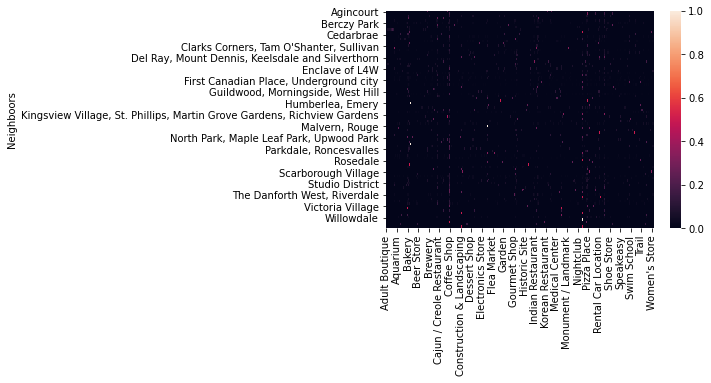

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighboors'] = toronto_venues['Neighboors'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]
toronto_grouped = toronto_onehot.groupby('Neighboors').mean().reset_index()

ax = sns.heatmap(toronto_grouped.set_index('Neighboors'))

In [20]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [21]:
import numpy as np

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighboors']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighboors'] = toronto_grouped['Neighboors']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighboors,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Breakfast Spot,Lounge,Clothing Store,Latin American Restaurant,Miscellaneous Shop,Moroccan Restaurant,Monument / Landmark,Molecular Gastronomy Restaurant,Modern European Restaurant,Mobile Phone Shop
1,"Alderwood, Long Branch",Pizza Place,Pub,Sandwich Place,Coffee Shop,Skating Rink,Moroccan Restaurant,Monument / Landmark,Molecular Gastronomy Restaurant,Modern European Restaurant,Miscellaneous Shop
2,"Bathurst Manor, Wilson Heights, Downsview North",Bank,Coffee Shop,Shopping Mall,Ice Cream Shop,Diner,Sandwich Place,Gas Station,Intersection,Frozen Yogurt Shop,Sushi Restaurant
3,Bayview Village,Japanese Restaurant,Bank,Chinese Restaurant,Café,Monument / Landmark,Museum,Movie Theater,Motel,Moroccan Restaurant,Molecular Gastronomy Restaurant
4,"Bedford Park, Lawrence Manor East",Restaurant,Sandwich Place,Coffee Shop,Juice Bar,Indian Restaurant,Sushi Restaurant,Café,Butcher,Pub,Thai Restaurant


5. Cluster Toronto neighbors according to its most common places and visualize info 

In [22]:
from sklearn.cluster import KMeans

kclusters = 5
toronto_grouped_clustering = toronto_grouped.drop('Neighboors', 1)
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# add clustering labels
# neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
neighborhoods_venues_sorted['Cluster Labels'] = pd.Series(kmeans.labels_, dtype=int)
toronto_merged = toronto_geodata
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighboors'), on='Neighboors')
toronto_merged.dropna(inplace=True)
toronto_merged.head()

,PostalCode,Borough,Neighboors,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
0,M3A,North York,Parkwoods,43.753259,-79.329656,Fast Food Restaurant,Park,Food & Drink Shop,Moroccan Restaurant,Martial Arts School,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,1.0
1,M4A,North York,Victoria Village,43.725882,-79.315572,Pizza Place,Coffee Shop,Hockey Arena,Portuguese Restaurant,Metro Station,Mexican Restaurant,Men's Store,Middle Eastern Restaurant,Museum,Miscellaneous Shop,0.0
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,Coffee Shop,Park,Café,Bakery,Pub,Event Space,Beer Store,Sandwich Place,Sushi Restaurant,Electronics Store,0.0
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,Clothing Store,Shoe Store,Boutique,Sporting Goods Shop,Vietnamese Restaurant,Coffee Shop,Miscellaneous Shop,Gift Shop,Adult Boutique,Monument / Landmark,0.0
4,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494,Coffee Shop,Sushi Restaurant,Burrito Place,Yoga Studio,Burger Joint,Fried Chicken Joint,Café,Sandwich Place,Bar,Bank,0.0


In [23]:
import matplotlib.cm as cm
import matplotlib.colors as colors

map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], 
                                  toronto_merged['Neighboors'],toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [24]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
1,North York,Pizza Place,Coffee Shop,Hockey Arena,Portuguese Restaurant,Metro Station,Mexican Restaurant,Men's Store,Middle Eastern Restaurant,Museum,Miscellaneous Shop,0.0
2,Downtown Toronto,Coffee Shop,Park,Café,Bakery,Pub,Event Space,Beer Store,Sandwich Place,Sushi Restaurant,Electronics Store,0.0
3,North York,Clothing Store,Shoe Store,Boutique,Sporting Goods Shop,Vietnamese Restaurant,Coffee Shop,Miscellaneous Shop,Gift Shop,Adult Boutique,Monument / Landmark,0.0
4,Queen's Park,Coffee Shop,Sushi Restaurant,Burrito Place,Yoga Studio,Burger Joint,Fried Chicken Joint,Café,Sandwich Place,Bar,Bank,0.0
7,North York,Gym,Restaurant,Sporting Goods Shop,Sandwich Place,Caribbean Restaurant,Supermarket,Clothing Store,Beer Store,Coffee Shop,Japanese Restaurant,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
96,Downtown Toronto,Coffee Shop,Pub,Bakery,Café,Pizza Place,Italian Restaurant,Restaurant,Chinese Restaurant,Gastropub,Taiwanese Restaurant,0.0
97,Downtown Toronto,Coffee Shop,Café,Sandwich Place,Hotel,Japanese Restaurant,Gym,Sushi Restaurant,Bank,Restaurant,Deli / Bodega,0.0
99,Downtown Toronto,Sushi Restaurant,Japanese Restaurant,Coffee Shop,Gay Bar,Restaurant,Fast Food Restaurant,Burrito Place,Indian Restaurant,Mediterranean Restaurant,Pub,0.0
100,East Toronto Business,Yoga Studio,Auto Workshop,Pizza Place,Park,Restaurant,Butcher,Burrito Place,Skate Park,Brewery,Farmers Market,0.0


In [25]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
6,Scarborough,Fast Food Restaurant,Adult Boutique,Malay Restaurant,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,2.0


In [26]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
12,Scarborough,Home Service,Bar,Adult Boutique,Movie Theater,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,3.0


In [27]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
57,North York,Baseball Field,Adult Boutique,Malay Restaurant,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,4.0
101,Etobicoke,Baseball Field,Adult Boutique,Malay Restaurant,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,4.0
